# 1. Data Reading using pandas

In [1]:
import pandas as pd

df = pd.read_csv('../data/raw.csv')

df

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53040,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53041,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53042,53040,Is there any way to sleep better? I can't slee...,Anxiety
53043,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


<Axes: xlabel='status', ylabel='statement'>

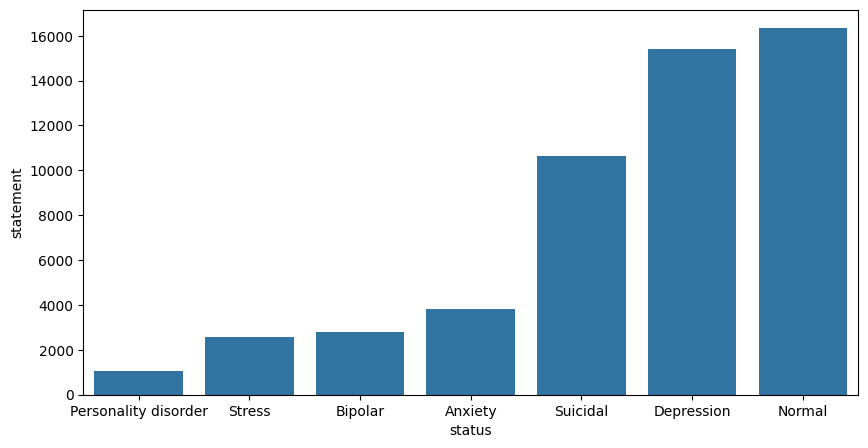

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

data = df.groupby('status')['statement'].count().sort_values().reset_index()
plt.figure(figsize = (10,5))
sns.barplot(data=data,x='status',y='statement')

# 2. Move each Correspondent status to each own list

depression list will only contains depression sentences and so are the rest.

In [3]:
depression = list()
personality_disorder = list()
bipolar = list()
anxiety = list()
stress = list()
normal = list()
suicide = list()

for i in range(len(df.status)):
    if df.status[i] == "Depression":
        depression.append(df.statement[i])
    elif df.status[i] == "Personality disorder":
        personality_disorder.append(df.statement[i])
    elif df.status[i] == "Bipolar":
        bipolar.append(df.statement[i])
    elif df.status[i] == "Anxiety":
        anxiety.append(df.statement[i])
    elif df.status[i] == "Stress":
        stress.append(df.statement[i])
    elif df.status[i] == "Normal":
        normal.append(df.statement[i])
    elif df.status[i] == "Suicidal":
        suicide.append(df.statement[i])
    else:
        continue

# 3. Labeled each sentences
"I'm so depressed" into ("I'm so depressed", "Depression")

In [4]:
labeled_sentences = list()

for sentence in depression:
    labeled_sentences.append((sentence, "Depression"))

for sentence in personality_disorder:
    labeled_sentences.append((sentence, "Personality Disorder"))

for sentence in bipolar:
    labeled_sentences.append((sentence, "Bipolar"))

for sentence in anxiety:
    labeled_sentences.append((sentence, "Anxiety"))

for sentence in stress:
    labeled_sentences.append((sentence, "Stress"))

for sentence in normal:
    labeled_sentences.append((sentence, "Normal"))

for sentence in suicide:
    labeled_sentences.append((sentence, "Suicidal"))

# 4. Seperates sentences and it's label into two different list

In [5]:
sentences = [str(sentence) for sentence, label in labeled_sentences]
labels = [str(label) for sentence, label in labeled_sentences]

Preprocess each sentences

In [6]:
import spacy
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

def understand_text(text: str) -> str:
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return ' '.join(tokens)

In [7]:
import re
from string import punctuation

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\[\]]*', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [8]:
from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')

def remove_stopwords(text: str) -> str:
    return ' '.join([word for word in text.split() if word not in eng_stopwords])

In [9]:
unique_dict = {}

for sentence, label in zip(sentences, labels):
    if sentence not in unique_dict:
        unique_dict[sentence] = label
    if sentence == "" or sentence == "NaN":
        continue

unique_sentences = list(unique_dict.keys())
unique_labels = list(unique_dict.values())

In [10]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text: str) -> str:
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [13]:
unique_sentences = [preprocess_text(sentence) for sentence in unique_sentences]
unique_sentences = [remove_stopwords(sentence) for sentence in unique_sentences]
unique_sentences = [understand_text(sentence) for sentence in unique_sentences]
unique_sentences = [stem_text(sentence) for sentence in unique_sentences]

# 5. Use TF-IDF to convert each sentences into a Vector Representative of words based on it's context.

In [14]:
import tensorflow as tf

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(unique_sentences)
sequences = tokenizer.texts_to_sequences(unique_sentences)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=500, padding='post')

padded_sequences

array([[ 141,    8, 1358, ...,    0,    0,    0],
       [   5, 2976,    2, ...,    0,    0,    0],
       [ 834,   42,   23, ...,    0,    0,    0],
       ...,
       [ 444,  370,    6, ...,    0,    0,    0],
       [  13,    2,  873, ...,    0,    0,    0],
       [ 367, 3426,  661, ...,    0,    0,    0]])

# 6. Encode the label into a matrix "Depression" into 2, "Suicidal" into 6 and etc.

In [15]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
label_arrays = encoder.fit_transform(unique_labels)
label_arrays = tf.keras.utils.to_categorical(label_arrays)

label_arrays

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

# 7. Data training with (90:5:5) format

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, label_arrays, test_size=0.1, random_state=768)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=768)

# 8. Create the neural network

In [17]:
# Check the shape of the training and validation data
print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")

# Ensure the input shape matches the model's expected input shape
input_shape = (500,)  # Example input shape, adjust as needed

# Reshape the data if necessary
x_train = x_train.reshape((-1, *input_shape))
x_val = x_val.reshape((-1, *input_shape))

# Verify the reshaped data
print(f"Reshaped x_train shape: {x_train.shape}")
print(f"Reshaped x_val shape: {x_val.shape}")

x_train shape: (45962, 500)
x_val shape: (2554, 500)
Reshaped x_train shape: (45962, 500)
Reshaped x_val shape: (2554, 500)


In [18]:
initializer = tf.keras.initializers.HeNormal()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 64, input_length=500),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation = 'softmax')
])


c:\Users\Hendra Wijaya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, clipnorm=1.0)

model.compile(  optimizer=optimizer, 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(  monitor='val_loss', 
                                                    patience=5, 
                                                    restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.5, 
                                                    patience=1,)

In [21]:
history = model.fit(x_train,
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(x_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 460s 316ms/step - accuracy: 0.4912 - loss: 1.3742 - val_accuracy: 0.6570 - val_loss: 0.8335 - learning_rate: 2.0000e-04
Epoch 2/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 419s 291ms/step - accuracy: 0.6666 - loss: 0.8635 - val_accuracy: 0.6762 - val_loss: 0.7863 - learning_rate: 2.0000e-04
Epoch 3/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 403s 280ms/step - accuracy: 0.7066 - loss: 0.7735 - val_accuracy: 0.6997 - val_loss: 0.7521 - learning_rate: 2.0000e-04
Epoch 4/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 372s 259ms/step - accuracy: 0.7316 - loss: 0.7317 - val_accuracy: 0.7279 - val_loss: 0.7370 - learning_rate: 2.0000e-04
Epoch 5/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 363s 253ms/step - accuracy: 0.7630 - loss: 0.6681 - val_accuracy: 0.7279 - val_loss: 0.7311 - learning_rate: 2.0000e-04
Epoch 6/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 356s 248ms/step - accuracy: 0.7870 - loss: 0.6217 - val_accuracy: 0.7408 - val_loss: 0.7114 - learning_rate: 2.0000e-04
Epoch 7/10
1437/1437 ━━━━━━━

In [22]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy with Neural Network: {accuracy}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.7333 - loss: 0.7736
Test Accuracy with Neural Network: 0.7332549691200256


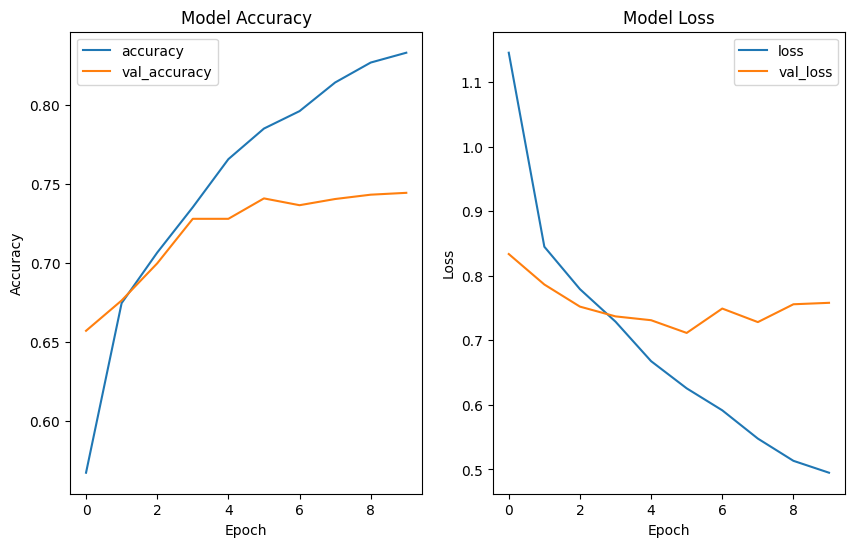

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [24]:
test = input()
test = preprocess_text(test)
test = remove_stopwords(test)
test = understand_text(test)
test = stem_text(test)
test_sequence = tokenizer.texts_to_sequences([test])
test_vector = tf.keras.preprocessing.sequence.pad_sequences(test_sequence, maxlen=500, padding='post')


prediction = model.predict(test_vector)
prediction = encoder.inverse_transform([prediction.argmax()])

print(f"Prediction: {prediction[0]}\n\n")
print("Percentages:")

labels = ["Anxiety", "Bipolar", "Depression", "Normal", "Personality Disorder", "Stress", "Suicidal"]
for i, label in enumerate(labels):
    percentage = model.predict(test_vector)[0][i] * 100  # Convert to percentage
    print(f"{label}: {percentage:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
Prediction: Stress


Percentages:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Anxiety: 21.95%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Bipolar: 1.28%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Depression: 4.46%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Normal: 31.85%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Personality Disorder: 4.32%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Stress: 35.83%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Suicidal: 0.31%


In [25]:
model.save('../models/model.keras')
model.save('../models/model.h5')